In [56]:
import pandas as pd
import seaborn as sb
import numpy as np

In [57]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB
import emoji
import re
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gc
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [59]:
train_data = pd.read_csv('./datasets/training-v1/offenseval-training-v1.tsv' , sep='\t')

## Exploratory Data Analysis

In [60]:
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


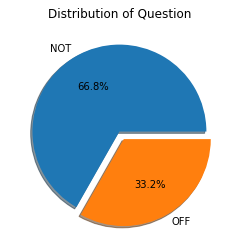

In [62]:
ax=train_data['subtask_a'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Offensive:  4400
Not Offensive :  8840


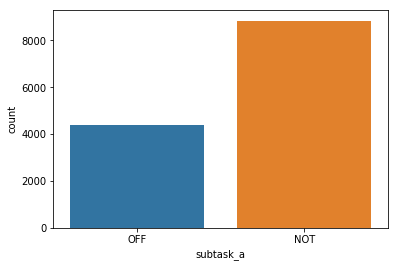

In [63]:
plot_sb = sb.countplot(train_data['subtask_a'], label='Total')
NOT, OFF  = train_data['subtask_a'].value_counts()
print('Offensive: ',OFF)
print('Not Offensive : ',NOT)

## Preprocessing Dataset

In [64]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text


In [65]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [66]:
train_data['subtask_a'].replace({'NOT':0, 'OFF': 1}, inplace= True)

In [67]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

In [68]:
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN,<user> obama wanted liberals and amp illegals ...


In [69]:
train_data.shape

(13240, 6)

## Word Cloud

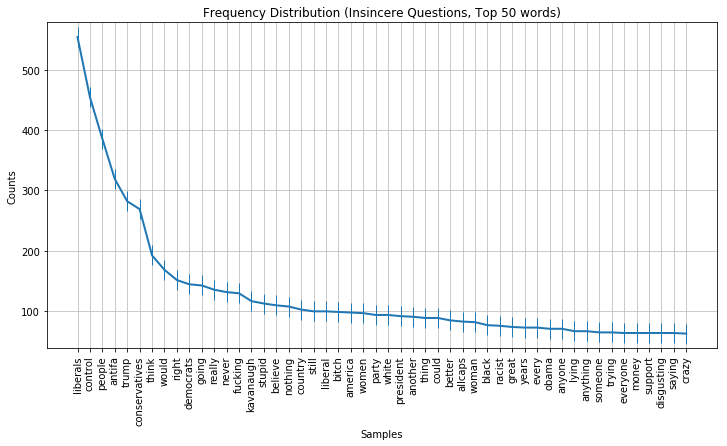

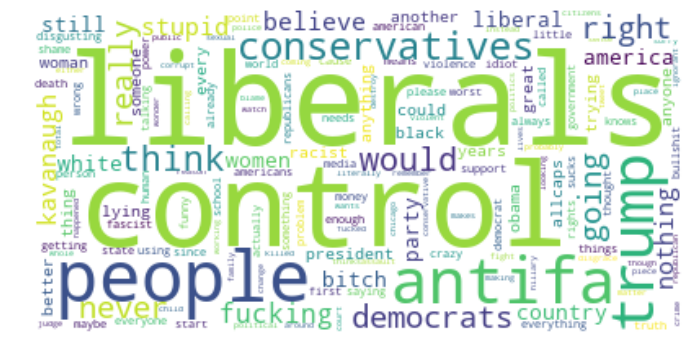

In [70]:
offensive = train_data.loc[train_data['subtask_a'] == 1].values
len(offensive)
offensive[0][1]

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[5]) for question in offensive]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])
all_words = [word for question in word_tokens for word in question]
len(all_words)
without_stopwords = [w for w in all_words if not w in stop_words]
words_len = [w for w in without_stopwords if not len(w)<5]
freq_dist = FreqDist([word for word in words_len])

plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Extraction

In [71]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_a"].values

In [72]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [73]:
print("Train shape : ",train_X.shape)
print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (8937,)
Validation shape :  (993,)
Test shape :  (3310,)


In [19]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5967]
 [   1 2970]]
[[  0 663]
 [  1 330]]
[[   0 2210]
 [   1 1100]]


In [74]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_a'] = test_y
testdf.shape

(3310, 2)

### Tokenize the sentences

In [75]:
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


In [76]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

### Pad the sentences

In [77]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [78]:
len(train_X)

8937

In [79]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,   44, 3930, 4924, 3931,
         26,   60, 1160, 3264, 1718,   55, 4925,   10,  220,  551,    2,
       2807], dtype=int32)

In [80]:

S_DROPOUT = 0.4
DROPOUT = 0.1

In [81]:
train_X.shape

(8937, 100)

In [28]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5967]
 [   1 2970]]
[[  0 663]
 [  1 330]]
[[   0 2210]
 [   1 1100]]


## Function for Plotting

In [107]:
def plotting(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()    

## Function for Confusion Matrix

In [109]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  #plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

## Undersampling

In [84]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled


## Oversampling

In [85]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

# Model

## Without pretrained embeddings

In [86]:
embed_size = 100

In [87]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [88]:
#X_resampled, y_resampled = undersampleData(train_X, train_y)
X_resampled, y_resampled = train_X, train_y
#X_resampled, y_resampled = oversampleData(train_X, train_y)

Train on 8937 samples, validate on 993 samples
Epoch 1/15
8937/8937 [==============================] - 19s 2ms/step - loss: 0.6600 - acc: 0.6510 - val_loss: 0.6500 - val_acc: 0.6677
Epoch 2/15
8937/8937 [==============================] - 17s 2ms/step - loss: 0.6404 - acc: 0.6677 - val_loss: 0.6333 - val_acc: 0.6677
Epoch 3/15
8937/8937 [==============================] - 21s 2ms/step - loss: 0.6279 - acc: 0.6678 - val_loss: 0.6197 - val_acc: 0.6677
Epoch 4/15
8937/8937 [==============================] - 18s 2ms/step - loss: 0.5773 - acc: 0.6922 - val_loss: 0.6067 - val_acc: 0.6858
Epoch 5/15
8937/8937 [==============================] - 16s 2ms/step - loss: 0.4762 - acc: 0.8081 - val_loss: 0.5706 - val_acc: 0.7251
Epoch 6/15
8937/8937 [==============================] - 17s 2ms/step - loss: 0.4159 - acc: 0.8313 - val_loss: 0.5416 - val_acc: 0.7553
Epoch 7/15
8937/8937 [==============================] - 17s 2ms/step - loss: 0.3277 - acc: 0.8825 - val_loss: 0.5932 - val_acc: 0.7573
Epoch 8/

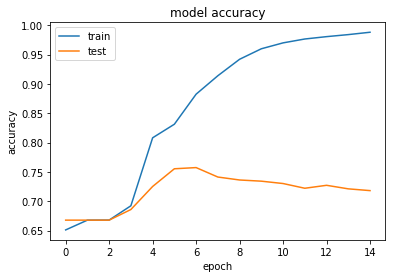

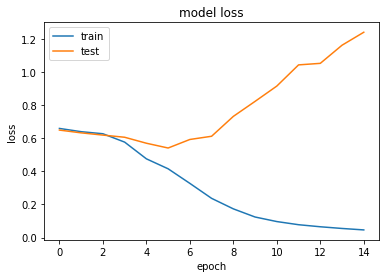

Test Accuracy: 72.296073


In [89]:
## Train the model 
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=15, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [90]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

993/993 [==============================] - 1s 1ms/step


In [91]:
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.5808219178082192
F1 score at threshold 0.11 is 0.577716643741403
F1 score at threshold 0.12 is 0.5757997218358831
F1 score at threshold 0.13 is 0.5798319327731092
F1 score at threshold 0.14 is 0.5814606741573034
F1 score at threshold 0.15 is 0.5802816901408452
F1 score at threshold 0.16 is 0.5782792665726375
F1 score at threshold 0.17 is 0.5795454545454546
F1 score at threshold 0.18 is 0.5787965616045845
F1 score at threshold 0.19 is 0.5787965616045845
F1 score at threshold 0.2 is 0.5784172661870504
F1 score at threshold 0.21 is 0.5772005772005772
F1 score at threshold 0.22 is 0.5768115942028986
F1 score at threshold 0.23 is 0.5755813953488371
F1 score at threshold 0.24 is 0.5760233918128655
F1 score at threshold 0.25 is 0.5756240822320119
F1 score at threshold 0.26 is 0.5722713864306784
F1 score at threshold 0.27 is 0.5731166912850812
F1 score at threshold 0.28 is 0.5727002967359051
F1 score at threshold 0.29 is 0.5701492537313433
F1 score at threshold 0

In [92]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y =  (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

3310/3310 [==============================] - 2s 552us/step
[[   0 2015]
 [   1 1295]]


Sensitivity: 73.82%
Specificity: 74.39%


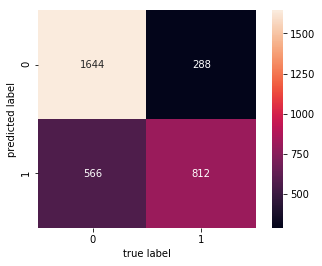

In [110]:
getConfusionMatrix(test_y, pred_test_y)

In [94]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.6810663240725872
0.6903743315508022
0.677357080582887


In [95]:
testdf['predicted target'] = pred_test_y
testdf.head()

,tweet,subtask_a,predicted target
0,<user> all great american patriots are the dre...,1,1
1,<user> cause who bitches be playing with cry g...,1,1
2,<user> russia agent fake republican devin nune...,0,1
3,<user> thank you president trump ! you are maga !,0,0
4,<user> god speed bandit <url>,0,0


## Using GloVe Embeddings

In [96]:
embed_size = 200

In [97]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove/glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [98]:
from numpy import zeros
# create a weight matrix for words in training docs
embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [99]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 200)          10000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          135680    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [100]:
#X_resampled, y_resampled = undersampleData(train_X, train_y)
X_resampled, y_resampled = train_X, train_y
#X_resampled, y_resampled = oversampleData(train_X, train_y)

Train on 8937 samples, validate on 993 samples
Epoch 1/10
8937/8937 [==============================] - 31s 3ms/step - loss: 0.1207 - acc: 0.9616 - val_loss: 0.7873 - val_acc: 0.7482
Epoch 2/10
8937/8937 [==============================] - 36s 4ms/step - loss: 0.0922 - acc: 0.9737 - val_loss: 0.9432 - val_acc: 0.7503
Epoch 3/10
8937/8937 [==============================] - 31s 3ms/step - loss: 0.0716 - acc: 0.9800 - val_loss: 1.0573 - val_acc: 0.7462
Epoch 4/10
8937/8937 [==============================] - 31s 4ms/step - loss: 0.0595 - acc: 0.9848 - val_loss: 1.0481 - val_acc: 0.7412
Epoch 5/10
8937/8937 [==============================] - 27s 3ms/step - loss: 0.0461 - acc: 0.9893 - val_loss: 1.2022 - val_acc: 0.7422
Epoch 6/10
8937/8937 [==============================] - 23s 3ms/step - loss: 0.0373 - acc: 0.9905 - val_loss: 1.4150 - val_acc: 0.7462
Epoch 7/10
8937/8937 [==============================] - 22s 3ms/step - loss: 0.0327 - acc: 0.9917 - val_loss: 1.4503 - val_acc: 0.7392
Epoch 8/

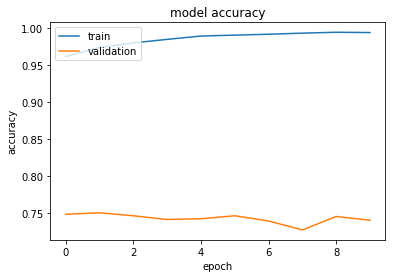

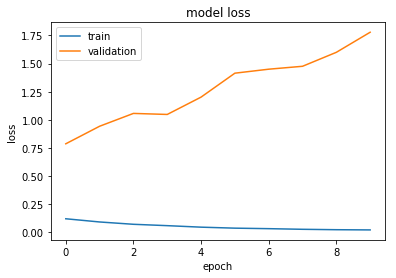

Test Accuracy: 74.441088


In [108]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=10, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [111]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)


993/993 [==============================] - 1s 797us/step
F1 score at threshold 0.1 is 0.5832012678288431
F1 score at threshold 0.11 is 0.5841269841269842
F1 score at threshold 0.12 is 0.5828025477707006
F1 score at threshold 0.13 is 0.5810593900481541
F1 score at threshold 0.14 is 0.5838709677419354
F1 score at threshold 0.15 is 0.5848142164781907
F1 score at threshold 0.16 is 0.5834683954619124
F1 score at threshold 0.17 is 0.5834683954619124
F1 score at threshold 0.18 is 0.5798045602605865
F1 score at threshold 0.19 is 0.5798045602605865
F1 score at threshold 0.2 is 0.5798045602605865
F1 score at threshold 0.21 is 0.580327868852459
F1 score at threshold 0.22 is 0.5779967159277504
F1 score at threshold 0.23 is 0.5766062602965403
F1 score at threshold 0.24 is 0.5742574257425742
F1 score at threshold 0.25 is 0.5752066115702479
F1 score at threshold 0.26 is 0.576158940397351
F1 score at threshold 0.27 is 0.5737976782752902
F1 score at threshold 0.28 is 0.5737976782752902
F1 score at thre

In [103]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

3310/3310 [==============================] - 3s 793us/step
[[   0 1932]
 [   1 1378]]


Sensitivity: 73.82%
Specificity: 74.39%


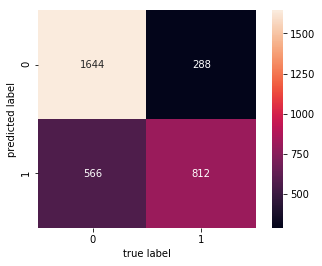

In [112]:
getConfusionMatrix(test_y, pred_test_y)

In [105]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.7245933212755103
0.7410366104483752
0.7200957369128


In [106]:
testdf['predicted target - GloVe'] = pred_test_y
testdf.head()

,tweet,subtask_a,predicted target,predicted target - GloVe
0,<user> all great american patriots are the dre...,1,1,1
1,<user> cause who bitches be playing with cry g...,1,1,1
2,<user> russia agent fake republican devin nune...,0,1,1
3,<user> thank you president trump ! you are maga !,0,0,0
4,<user> god speed bandit <url>,0,0,0
